# Machine Learning Project

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import preprocessing
import itertools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



## Data Preprocessing

In [5]:
#Reading in the two data set
test = pd.read_csv ('df_test.csv', sep = ',')
train = pd.read_csv('df_train.csv', sep = ',')

#Making train data without classes and standardizing
x_train = train.drop(columns = ['type'])
x_train = preprocessing.scale(x_train)
y_train = train['type']

#Making test data without classes and standardizing
x_test = test.drop(columns = ['type'])
x_test = preprocessing.scale(x_test)
y_test = test['type']



features = list(train.columns.values[:-1])


## Kfold function

In [6]:


from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def kfolds_predict(x_train, y_train, clf, folds):

    """
    A function that implements Kfolds on a data set.
    Returns the mean f1-score and accuracy of the k-folds

    """

    kf = KFold(n_splits=folds)

    acc_list = []
    f1_list = []

    for train_i, test_i in kf.split(x_train):

        X_train, X_test = x_train[train_i], x_train[test_i]
        Y_train, Y_test = y_train[train_i], y_train[test_i]
        
        clf.fit(X_train, Y_train)
        preds = clf.predict(X_test)

        # accuracy_score(Y_test, preds)
        acc_list.append(accuracy_score(Y_test, preds))

        f1_list.append( f1_score(Y_test, preds, average='macro'))




    
    return np.mean(f1_list), np.mean(acc_list)

## Scatterplots

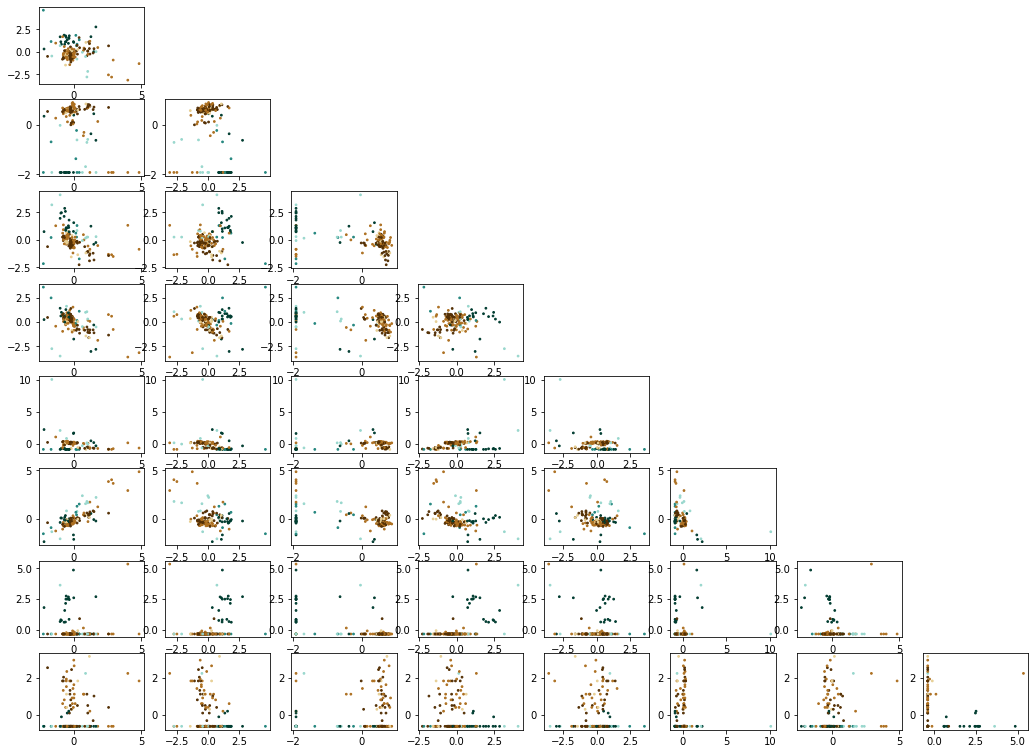

In [135]:

#Make the 9x9 plot of all nine features scattered agains each other pair wise
fig,ax = plt.subplots(9,9, figsize = (20,15))

sub_train = x_train[:,0:3]
sub_label = y_train

f_1 = [0,1,2,3,4,5,6,7,8]
f_2 = [0,1,2,3,4,5,6,7,8]


combinations = [i for i in itertools.product(f_1,f_2)]


unique_combs = []

#Making sure we don't have duplicates of pairs
for comb in combinations:
    x = sorted(comb)
    if x in unique_combs:
        continue
    else:
        unique_combs.append(x)
    


    
#Plotting the scatter plots
for i in unique_combs:
    ax[i[1],i[0]].scatter(x_train[:,i[0]], x_train[:,i[1]], c=y_train, cmap='BrBG', s=3)
    fig.delaxes(ax[i[0],i[1]])
    #ax[i[1],i[0]].set(xlabel = features[i[0]])
    #if i[0] == 0:
    #    ax[i[1],i[0]].set(ylabel = features[i[1]])
    

fig.savefig('Scatter.png')


## SVM Classifier 

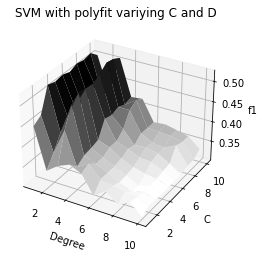

We can see that the best combination of parameters are C = 8.0 and D = 3.0 
 with an f1 of:  0.5228453213453214 %


In [7]:
#starting finding the optimal degree D and C for poly fit

#Specifying which values of C and D we iterate through
D = np.linspace(1, 10, 10)
C = np.linspace(1, 10, 10)
z = np.ones((10,10))

acc_list = []
f1_list = []

#Iterating through the different combinations of C and D and calculating f1 and accuracy
for index, (c, d) in enumerate(itertools.product(C,D)):
    clf_poly = svm.SVC(kernel="poly", degree=d, C = c,  decision_function_shape='ovo')

    f1, acc = kfolds_predict(x_train, y_train, clf_poly, folds=10)

    z[int(c)-1,int(d)-1] = f1
    acc_list.append([acc, (c,d)])
    f1_list.append([f1, (c, d)])
    
best_degree = int(max(acc_list)[1][1])
    
X, Y = np.meshgrid(C,D)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



# Plot the surface
ax.plot_surface(X, Y, z, color='r', cmap='binary')
ax.set(xlabel='Degree')
ax.set(zlabel='f1')

ax.set(ylabel='C')


plt.title('SVM with polyfit variying C and D')

plt.show()

print('We can see that the best combination of parameters are C =', max(f1_list)[1][0], 'and D =', max(f1_list)[1][1],'\n','with an '
     'f1 of: ', max(f1_list)[0], '%')



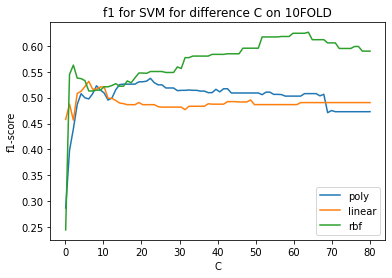

In [8]:
#Comparing different kernel functions and different C-values for SVM

#Defining all different C values
x = np.linspace(0.1, 80.0, 80)
names = ["poly", "linear", "rbf"]


all_f1_results = []
all_acc_results = []

highest_score = -1
best_kernel = [0]

#Trying different combinations
for name in names:

    results = []
    f1_test_list = []
    acc_test_list = []

    f1_list = []
    acc_list = []
    

    


    for i in range(len(x)):

        #degree is only important for the poly

        clf = svm.SVC(kernel=name, degree=best_degree, C=x[i] , decision_function_shape='ovo')

        f1, acc = kfolds_predict(x_train, y_train, clf, folds=10)
        acc_list.append( acc )
        f1_list.append( f1 )
        if f1 > highest_score:
            highest_score = f1
            best_kernel[0] = name
        else:
            continue

        
    plt.title("f1 for SVM for difference C on 10FOLD")

    plt.plot(x, f1_list, label = name)

    plt.legend()

    plt.xlabel('C')

    plt.ylabel('f1-score')


    all_acc_results.append(acc_list)
    all_f1_results.append(f1_list)

plt.savefig('SVM_kernel.png')

## Final results SVM

In [10]:
#From the plot above we see that rbf is the best function
f1_svm_kfold = np.max(all_f1_results[2])
acc_svm_kfold = np.max(all_acc_results[2])

print("we can see that the best parameters are C = " + str(np.argmax(all_f1_results[2]) ) + ' and the', best_kernel[0], 'function')
#trying on test set with optimized parameters

final_svm_results = {"kfold_f1": None, "kfold_acc": None, "testset_f1": None, "testset_acc": None}

#Training with best hyper-parameters
clf = svm.SVC(kernel="rbf", C=63 , decision_function_shape='ovo')
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
acc_svm_test = accuracy_score(y_test, preds)  
f1_svm_test = f1_score(y_test, preds, average="macro")


final_svm_results["testset_acc"] = acc_svm_test
final_svm_results["testset_f1"] = f1_svm_test
final_svm_results["kfold_f1"] = f1_svm_kfold
final_svm_results["kfold_acc"] = acc_svm_kfold


print(final_svm_results)





we can see that the best parameters are C = 63 and the rbf function
{'kfold_f1': 0.6261105838605838, 'kfold_acc': 0.6780952380952381, 'testset_f1': 0.7573918456271397, 'testset_acc': 0.7538461538461538}


## Decision Trees


In [11]:
#Helper class for constructing tree
class Node:
    def __init__(self, gini, samples, samples_pr_class, predict_class):
        self.gini = gini
        self.samples = samples
        self.samples_pr_class = samples_pr_class
        self.predict_class = predict_class
        self.feature_i = 0
        self.split_value = 0
        self.left = None
        self.right = None


#Decision Tree Class
class DescTree: 
    def __init__(self, max_depth = 10):
        """Takes a max_depth hyperparameter to ensure no overfitting happens"""
        self.max_depth = max_depth #max depth of tree
        self.target_val = 0 #target value that bool_check compares to
        self.best_q = None #best value to spit the dataset on
        self.best_feature = None #best feature to split the dataset in

    def bool_check(self, test_val):
        """Checks if a value is greater or equal to a target value, returns True/False"""
        return test_val >= self.target_val

    def split(self, X):
        """Splits data into left and right arrays (True/False) on a condition checked in our bool_check function """
        left_data, right_data = [], []
        for row in X:
            if self.bool_check(row) == True:
                left_data.append(row)
            else: 
                right_data.append(row)
        return left_data, right_data

    def calculate_gini(self,y):
        """ Calculates a gini_score  """
        classes, count = np.unique(y, return_counts=True)
        gini = 1 
        for p in range(len(classes)):
            pik = count[p]/np.sum(count)
            gini -= pik**2
        return gini
        
    def info_gain(self, left_data, right_data, gini):
        """Calculates an info_gain_score by calling the calculate_gini function"""
        prior = float(len(left_data)) / (len(left_data) + len(right_data))
        info = gini - (prior * self.calculate_gini(left_data)) - ((1-prior)* self.calculate_gini(right_data))
        return info

    def best_split(self, X,y):
        """Finds the best value to split on by itterating through each row in each feature, 
        saves the best info gain, best value and best feature while itterating and 
        returns the best feature + value that gives the highest info gain.  """
        best_info_gain = -10 
        best_bool_check = None
        best_feature = None
        rows, features = X.shape
        for feature in range(features):
            unique = np.unique(X[:,feature])
            for u in unique:
                impurity = self.calculate_gini(y)
                self.target_val = u
                LD, RD = self.split(X[:,feature])
                if len(LD) == 0 or len(RD) == 0:
                    continue
                info = self.info_gain(LD, RD, impurity)

                if info >= best_info_gain:
                    
                    best_info_gain, best_bool_check, best_feature = info, self.target_val, feature

        self.best_feature = best_feature
        self.best_q = best_bool_check
        return self.best_q, self.best_feature, best_info_gain

    def fit(self, X, y):
        """Fits the data, calls all our functions inside this class"""
        self.n_features = X.shape[1] #9 features
        self.n_classes = len(set(y)) #6 classes
        self.tree = self.create_tree(X,y)


    
    def create_tree(self, X, y, depth = 0):
        """ A recursive function that creates a decision tree"""
        cl , samples_pr_class = np.unique(y, return_counts=True)
        yL = list(y)
        most_class = max(set(yL), key=yL.count)

        
        node = Node(gini = self.calculate_gini(y), samples = y.size, samples_pr_class = samples_pr_class, predict_class = most_class)



      
        #Making use of depth parameter
        if depth < self.max_depth:
            value, feat, info_gain = self.best_split(X,y)


            
            
            if feat != None:

                index = X[:,feat] < value


                X_left, y_left = X[index], y[index]
                X_right, y_right = X[~index], y[~index]


                node.feature_i = feat
                node.split_value = value 
                
                node.left = self.create_tree(X_left, y_left, depth + 1)
                
                node.right = self.create_tree(X_right, y_right, depth +1)

        return node

    def predict(self, X):
        """Calls another function that predicts the class for each row in a test dataset """
        predictions = []
        for values in X:
            node = self.tree

            while node.left:
                if values[node.feature_i] < node.split_value:

                    node = node.left
                    
                else:
                    node = node.right
            predictions.append(node.predict_class)
        return np.array(predictions)





## DT final results

In [12]:
dt = DescTree(max_depth = 10)

dt.fit(x_train,y_train)
pred = dt.predict(x_test)

accuracy_score(pred, y_test)
f1_score(pred, y_test, average="macro")

0.43492975734355044

In [13]:
final_dt_results = {"kfold_f1": 0.4676964655714656, 
                    "kfold_acc": 0.5647619047619047, 
                    "f1_score": 0.43492975734355044, 
                    "acc_score": 0.5846153846153846}

## K-nearest neighbours using 2 features that you have chosen by dimensionality reduction

In [41]:
# Making different data sets using PCA and LDA
lda = LDA(n_components=2)
pca = PCA(n_components=2)
lda_train = lda.fit_transform(x_train, y_train)
lda_test = lda.fit_transform(x_test, y_test)
pca_train = pca.fit_transform(x_train)
pca_test = pca.fit_transform(x_test)

pca_acc = []
pca_f1 = []

lda_acc = []
lda_f1 = []

knn_acc = []
knn_f1 = []

counts = []


#Calculating f1 and accuracy for different combinations of k-value and data
for k in range(1,15):
    counts.append(k)
    
    pca_knn = KNN(n_neighbors=k).fit(pca_train, y_train)
    f1pca, accpca = kfolds_predict(pca_train, y_train, KNN(n_neighbors=k), folds=10)
    pca_acc.append(accpca)
    pca_f1.append(f1pca)
    
    lda_knn = KNN(n_neighbors=k).fit(lda_train, y_train)
    f1lda, acclda = kfolds_predict(lda_train, y_train, KNN(n_neighbors=k), folds=10)
    lda_acc.append(acclda)
    lda_f1.append(f1lda)

    knn = KNN(n_neighbors=k).fit(x_train,y_train)
    f1knn, accknn = kfolds_predict(x_train, y_train, KNN(n_neighbors=k), folds=10)
    knn_acc.append(accknn)
    knn_f1.append(f1knn)

    # knn_results.append(knn_score)




Text(0, 0.5, 'f1-score')

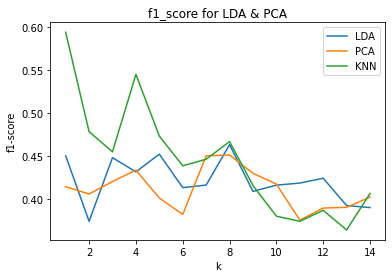

In [47]:
#Plotting f1_score of the different data

plt.plot(counts, lda_f1, label="LDA")
plt.plot(counts, pca_f1, label="PCA")
plt.plot(counts, knn_f1, label="KNN")
plt.legend()
plt.title("f1_score for LDA & PCA")
plt.xlabel('k')
plt.ylabel('f1-score')

## Final results KNN

In [51]:
# WE can see that the best f1 score happens in k = 1 and for the full dataset i.e. not dimensionality reduced.
#We will therefore use these parameters on the test set. 
best_kfold_acc = np.max(knn_acc)
best_kfold_f1 = np.max(knn_f1)


final_knn_results = {"kfold_f1": best_kfold_f1, "kfold_acc": best_kfold_acc, "testset_f1": None, "testset_acc": None}

#Fitting 
clf = KNN(n_neighbors=1)
clf.fit(x_train, y_train)

preds = clf.predict(x_test)


final_knn_results["testset_acc"] = accuracy_score(y_test, preds)
final_knn_results["testset_f1"] = f1_score(y_test, preds, average="macro")


print(final_knn_results)


{'kfold_f1': 0.5941535409035408, 'kfold_acc': 0.6847619047619047, 'testset_f1': 0.7112518744871686, 'testset_acc': 0.7384615384615385}


## Discriminant analysis

In [93]:
#Class modelling both LDA and QDA
class DiscriminantAnalysis:
    def __init__(self, model="LDA", bias=False):
        self.priors = []
        self.mean_total = []
        self.n_classes = None
        self.sigma = None
        self.hypothesis = []
        self.dictionary = {0:1, 1:2, 2:3, 3:5, 4:6, 5:7}
        self.g2sigma =[]
        self.model = model
        self.trained = False
        self.arr = None
        self.bias = bias

    def fit(self, X, y):
        '''
        Calculates means for each class, and finds weighted between class covariance matrix for LDA
        and within class covariance for QDA.
        '''
        
        n,m = X.shape
        self.n_classes = np.unique(y)
        self.sigma = np.zeros((m, m))


        for c in self.n_classes:
            X_k = X[y==c]
            prior = len(X_k)/n 
            self.priors.append(prior)
            mean = X_k.mean(axis =0)
            self.mean_total.append(mean)

            self.sigma += self.CovariMatrix(X_k, self.bias)*prior
            
            self.g2sigma.append(self.CovariMatrix(X_k, self.bias))
            

    def CovariMatrix(self, M, bias):
        '''
        Calculates and outputs within class covaraince matrices
        '''
        M = M
        n = M.shape[0]
        mean = M.mean(axis=0)
        X_c = M-mean
        
        if bias == True:
            return (1/(n-1)) * (X_c.T @ X_c)
        else:
            return (1/n) * (X_c.T @ X_c)


    def predict(self, X, ):
        
        '''
        Given a matrix X of test data, this functions calculates the discriminant functions for LDA or QDA,
        and returns the predicted classes for matrix X.
        '''

        self.hypothesis = []
        for point in X:


            hyp_point=[]
            for i,c in enumerate(self.n_classes):
                mu = self.mean_total[i].reshape((1,X.shape[1]))


                po = point.reshape((1,X.shape[1]))
                if self.model == "LDA":
                    g = 2*np.log(self.priors[i]) - (po - mu)@np.linalg.inv(self.sigma)@(po - mu).T
                elif self.model == "QDA":

                    const = 1/ (   (2*np.pi)**X.shape[1]/2 )

                    a = 2*np.log(self.priors[i]) - np.log(np.linalg.det(  (self.g2sigma[i])) ) - mu @ np.linalg.inv(self.g2sigma[i]) @ mu.T + const


                    b = 2*mu @ np.linalg.inv(self.g2sigma[i]) @ po.T

                    c = - po @ np.linalg.inv(self.g2sigma[i]) @ po.T 

                    g = a + b + c


                else:
                    return

                hyp_point.append(g[0][0])

            self.hypothesis.append(hyp_point)
        self.trained = True

        self.predict_proba()
        
        predictions = self.class_predict(np.argmax(self.hypothesis, axis=1))
        
        return np.array(list(predictions))

    def class_predict(self, array):
        '''
        Maps the predicted classes from predict to the right classes in the data set. 
        '''
        class_list = []
        
        for i in array:
            class_list.append(self.dictionary[i])
        return class_list
            

    def predict_proba(self):
        '''
        Finds the probability of each class
        '''
        
        
        hyp = np.array(self.hypothesis)
        hypp = np.zeros(hyp.shape)
        for i,row in enumerate(hyp):
            N = np.sum(np.exp(row))
            hypp[i,:] = np.round(np.exp(row)/N)
        self.hypothesis = hypp
    
    def accuracy_score(self,X, y):
        '''
        Returns the accuracy of our model on a test set X 
        '''
        if not self.trained:
            print("No model trained")
            return
        predictions = self.predict(X)
        bool_array = predictions==y
        n = np.sum(bool_array)/len(predictions)
        return n
    
        



## LDA results



In [102]:


#LDA on all features and all classes. Gives the excact same results at SKlearns. 
#Implemented with G function and within class covariance

#Making kfold result
lda = DiscriminantAnalysis(model = "LDA")

f1, acc = kfolds_predict(x_train, y_train, lda, 10)

final_lda_results = {"kfold_f1": f1, "kfold_acc": acc, "testset_f1": None, "testset_acc": None}


#Making test results
lda2 = DiscriminantAnalysis(model = "LDA")
lda2.fit(x_train, y_train)
preds = lda2.predict(x_test)


final_lda_results["testset_acc"] = accuracy_score(y_test, preds)
final_lda_results["testset_f1"] = f1_score(y_test, preds, average="macro")

print(final_lda_results)










{'kfold_f1': 0.515484126984127, 'kfold_acc': 0.6242857142857143, 'testset_f1': 0.5325241207594149, 'testset_acc': 0.6}


## QDA Results

In [106]:
#QDA on dimnesionality reduced data, since we have some features with equal data, 
#which gives us a 0 determinant on some within class covariance matrices, 
#and therefore it is impossible to do the inverse which are requiered in the formula for the g function. 
#Thus we reduced the data with PCA

#Making results for kfold
qda = DiscriminantAnalysis(model = "QDA")
x_train_transformed = PCA(n_components=4).fit_transform(x_train)
x_test_transformed =  PCA(n_components=4).fit_transform(x_test)



f1, acc = kfolds_predict(x_train_transformed, y_train, qda, 10)

final_qda_results = {"kfold_f1": f1, "kfold_acc": acc, "testset_f1": None, "testset_acc": None}

#Making results for test data
qda2 = DiscriminantAnalysis(model = "QDA")
qda2.fit(x_train_transformed, y_train)
preds = qda2.predict(x_test_transformed)

final_qda_results["testset_acc"] = accuracy_score(y_test, preds)
final_qda_results["testset_f1"] = f1_score(y_test, preds, average="macro")

print(final_qda_results)

{'kfold_f1': 0.6050465699877463, 'kfold_acc': 0.6580952380952381, 'testset_f1': 0.5469733567559655, 'testset_acc': 0.5384615384615384}


# Neural Network

In [107]:
np.random.seed(1)

#Finds best combination of activation- and solver functions

activations = ['identity', 'logistic', 'tanh', 'relu']
solvers = ['lbfgs', 'sgd', 'adam']
#This is the default alpha value
alpha = 0.0001

best_functions = []
for index, (act, solv) in enumerate(itertools.product(activations,solvers)):
    clf = MLPClassifier(hidden_layer_sizes = (10,10,10), max_iter=20000000, activation = act, alpha=alpha, solver=solv)
    best_functions.append([kfolds_predict(x_train, y_train, clf, 10), (act,solv)])

/Users/Morten/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Morten/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [108]:

best_functions = np.array(best_functions)
#best solver and activation functions
best_functions[np.argmax(best_functions[:,0][:,0])]

array([['0.49570192770192767', '0.6233333333333334'],
       ['relu', 'lbfgs']], dtype='<U32')

In [109]:
np.random.seed(1)

#This process is difficult to show, as we manually tried different combinations of the parameters show below.

n, m = x_train.shape

#These parameters were the best we found

hl = (100, 100)
alpha = 0.0001
bs = min(20, n)
mi = 2000
lr = 0.001

new_clf = MLPClassifier(hidden_layer_sizes = hl,
                        max_iter=mi,
                        alpha = alpha,
                        activation = 'relu',
                        solver = 'adam',
                        batch_size = bs,
                        learning_rate_init = lr)



#Training model with kfold
Afold = kfolds_predict(x_train, y_train, new_clf, 10)

In [124]:
#Fitting the mod with our train data and reporting results on test dat 
new_clf.fit(x_train, y_train)

pred = new_clf.predict(x_test)


In [125]:
final_NN_results = {"kfold_f1": np.round(Afold[0], 3),
                    "kfold_acc":np.round(Afold[1], 3) ,
                    "f1_score":np.round(accuracy_score(pred, y_test),3),
                    "acc_score":np.round(f1_score(pred, y_test, average='macro'), 3)}

## Make final score sheet

In [126]:
#Here we makes a table showing f1 and accuracy for kfold and test set for all our models

models_labels = ["svm", "knn", "lda", "qda", "dt", "NN"]
models = [final_svm_results, final_knn_results, final_lda_results, final_qda_results, final_dt_results, final_NN_results]


score_dict = {}

for i,model in enumerate(models):

    score_dict[models_labels[i]] = list(model.values())



a = pd.DataFrame.from_dict( score_dict, orient="index", columns=["kfold_f1", "kfold_acc", "testset_f1", "testset_acc"]  )

a

,kfold_f1,kfold_acc,testset_f1,testset_acc
svm,0.626111,0.678095,0.757392,0.753846
knn,0.594154,0.684762,0.711252,0.738462
lda,0.515484,0.624286,0.532524,0.600000
qda,0.605047,0.658095,0.546973,0.538462
dt,0.467696,0.564762,0.434930,0.584615
NN,0.600000,0.684000,0.723000,0.673000



## Decision boundaries plot

In [127]:
#Here we make a function to plot the decision regions

def plot_decision_region1(clf,X,y,title, fig):
    ## Set up Grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    ## make predictions on the grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # make the plots
    fig.contourf(xx, yy, Z, alpha=0.4)
    fig.scatter(*X.T, c=y,s=20, edgecolor='k')
    clfname = str(type(clf)).split(".")[-1][:-2]
    fig.set_title(str(title))
    #plt.show()

In [128]:
# Training all the models
np.random.seed(1)

x_train_transformed = PCA(n_components=2).fit_transform(x_train)
x_test_transformed =  PCA(n_components=2).fit_transform(x_test)

NN_model = MLPClassifier(hidden_layer_sizes = hl,
                        max_iter=mi,
                        alpha = alpha,
                        activation = 'relu',
                        solver = 'adam',
                        batch_size = bs,
                        learning_rate_init = lr).fit(x_train_transformed, y_train)


dt_model = DescTree(max_depth=10)
dt_model.fit(x_train_transformed, y_train)

svm_model = svm.SVC(kernel="rbf", C=63 , decision_function_shape='ovo').fit(x_train_transformed, y_train)

knn_model = KNN(n_neighbors=1).fit(x_train_transformed, y_train)

lda_model = DiscAnal(model = "LDA")
lda_model.fit(x_train_transformed, y_train)

qda_model = DiscAnal(model = "QDA")
qda_model.fit(x_train_transformed, y_train)


models = [NN_model, dt_model, svm_model, knn_model, lda_model, qda_model]

names = ["NN", "DT", "SVM", "KNN", "LDA", "QDA"]







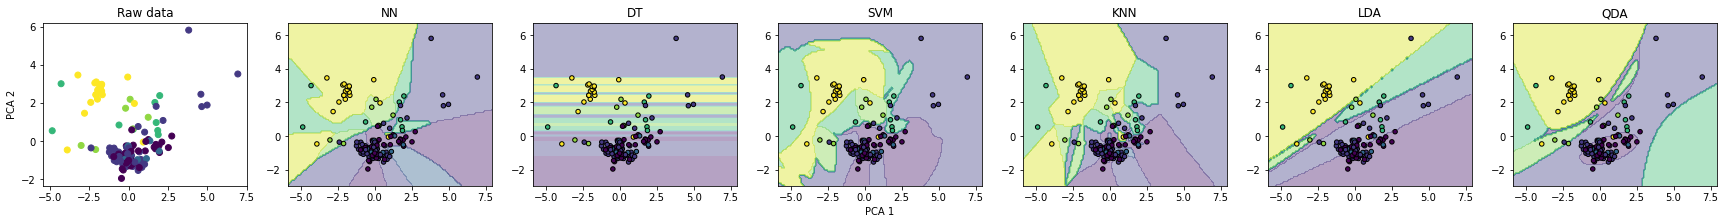

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [131]:
#Plotting decisions boundaries for all our models

fig,ax = plt.subplots(1,7, figsize = (30,3), sharey=False)



ax[0].scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y_train)
ax[0].set_title("Raw data")
ax[0].set_ylabel("PCA 2")
ax[3].set_xlabel("PCA 1")
for i,model in enumerate(models):
    i += 1
    plt.figure()
    # ax[i].set_ylabel("PCA 2")
    # ax[i].set_xlabel("PCA 1")
    plot_decision_region1(model, x_train_transformed, y_train, names[i-1], ax[i])




